LangGraph for Beginners, Part 4: StateGraph

In [1]:
!pip install autogen-agentchat~=0.2 autogen psutil --quiet
# !pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client==0.12.3 langgraph langchain_experimental yfinance
!pip install -q langchain-openai langchain-anthropic termcolor langchain_community duckduckgo_search wikipedia openapi-python-client langgraph langchain_experimental openai --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import autogen
from typing import Literal

from pydantic import BaseModel, Field
from typing_extensions import Annotated

import autogen
from autogen.cache import Cache
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langgraph.graph import END, StateGraph, START

INFERENCE_SERVER_URL = "http://localhost:8000"
MODEL_NAME = "ibm-granite/granite-3.0-8b-instruct"
API_KEY= "alanliuxiang"


In [3]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages: Annotated[list, add_messages]


llm = ChatOpenAI(
    openai_api_key=API_KEY,
    openai_api_base= f"{INFERENCE_SERVER_URL}/v1",
    model_name=MODEL_NAME,
    top_p=0.92,
    temperature=0.01,
    max_tokens=512,
    presence_penalty=1.03,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
)


# Create the structure of the schema for the graph.
class MyGraphState(TypedDict):
  count: int
  msg: str


# Define your node
def counter(state: MyGraphState):
  state["count"] += 1
  state["msg"] = f"Counter function has been called {state['count']} time(s)"
  return state

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
# Create an instance of StateGraph with the structure of MyGraphState
workflow = StateGraph(MyGraphState)

# Add three nodes to the workflow which are replicas of "counter"
workflow.add_node("Node1", counter)
workflow.add_node("Node2", counter)
workflow.add_node("Node3", counter)


# Add the nodes one after another. 
# All the Nodes in the workflow take state as input, update the state and pass it to the next Node as input.
# Output of Node1 goes to Node2 as input. Output of Node2 goes to Node3 as input.
workflow.add_edge(START, "Node1")
workflow.add_edge("Node1", "Node2")
workflow.add_edge("Node2", "Node3")

workflow.add_edge("Node3", END)


# Compile the workflow
app = workflow.compile()

# graph_builder.add_node("chatbot", chatbot)
# graph_builder.set_entry_point("chatbot")
# graph_builder.set_finish_point("chatbot")

# graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("chatbot", END)

# graph = graph_builder.compile()

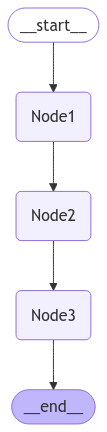

In [4]:
# Visualize your graph
from IPython.display import Image, display
png = app.get_graph().draw_mermaid_png()

display(Image(png))

In [5]:
app.invoke({"count": 0, "msg":"hello"})

{'count': 3, 'msg': 'Counter function has been called 3 time(s)'}